# Bitcoin 價格方向 Logistic Regression
利用 Binance 1 小時數據與技術指標，示範如何建立一個簡單的 Logistic Regression 模型來預測下一根 K 線的漲跌方向。

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-darkgrid')

## 載入原始資料
歷史資料使用 `scripts/download_data.py` 從 Binance 抓取並儲存在 `data/` 目錄。

In [2]:
PROJECT_ROOT = Path().resolve().parent
DATA_PATH = PROJECT_ROOT / 'data/btcusdt_1h.csv'
df = pd.read_csv(DATA_PATH, parse_dates=['open_time', 'close_time'])
df = df.sort_values('open_time').reset_index(drop=True)
df[['open', 'high', 'low', 'close', 'volume']] = df[['open', 'high', 'low', 'close', 'volume']].astype(float)
df.head()


,open_time,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_volume,taker_buy_quote_volume,ignore
0,2025-05-24 05:00:00+00:00,108485.06,108530.73,108126.99,108235.68,437.82917,2025-05-24 05:59:59.999000+00:00,4.742644e+07,84433.0,178.58541,1.934577e+07,0.0
1,2025-05-24 06:00:00+00:00,108235.69,108342.53,107683.96,107959.99,682.25870,2025-05-24 06:59:59.999000+00:00,7.362721e+07,127741.0,256.50189,2.768510e+07,0.0
2,2025-05-24 07:00:00+00:00,107959.99,108227.27,107566.37,107587.75,458.42202,2025-05-24 07:59:59.999000+00:00,4.948819e+07,86093.0,190.71759,2.059086e+07,0.0
3,2025-05-24 08:00:00+00:00,107587.75,108285.39,107587.74,108251.23,520.00591,2025-05-24 08:59:59.999000+00:00,5.612330e+07,99346.0,295.89243,3.193782e+07,0.0
4,2025-05-24 09:00:00+00:00,108251.23,108434.00,108158.09,108161.69,467.30605,2025-05-24 09:59:59.999000+00:00,5.060146e+07,81329.0,176.10537,1.906851e+07,0.0


## 特徵工程
五個指定因子 (Momentum, SMA, Volatility, RSI, Volume) 皆由 `close` 與 `volume` 推導：
- Momentum：24 小時報酬率
- SMA：24 小時簡單移動平均 (與現價的價差讓模型判斷偏離程度)
- Volatility：24 小時的報酬率標準差
- RSI：14 期 RSI 指標
- Volume：以 z-score 正規化的成交量

標籤定義為「下一個小時收盤價是否上漲」。

In [3]:
def compute_rsi(series: pd.Series, period: int = 14) -> pd.Series:
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(period).mean()
    avg_loss = loss.rolling(period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi.fillna(0)

df['momentum_24h'] = df['close'].pct_change(24)
df['sma_24h'] = df['close'].rolling(24).mean()
df['sma_distance'] = df['close'] - df['sma_24h']
log_return = np.log(df['close']).diff()
df['volatility_24h'] = log_return.rolling(24).std()
df['rsi_14'] = compute_rsi(df['close'], 14)
volume_z = (df['volume'] - df['volume'].rolling(24).mean()) / df['volume'].rolling(24).std()
df['volume_z'] = volume_z.fillna(0)

df['return'] = df['close'].pct_change()
df['future_return'] = df['return'].shift(-1)
df['target'] = (df['future_return'] > 0).astype(int)

feature_cols = ['momentum_24h', 'sma_distance', 'volatility_24h', 'rsi_14', 'volume_z']
df_features = df.dropna(subset=feature_cols + ['future_return'])
df_features = df_features.reset_index(drop=True)
df_features[feature_cols + ['target']].head()

,momentum_24h,sma_distance,volatility_24h,rsi_14,volume_z,target
0,-0.001217,-322.799583,0.003262,35.412648,-0.803580,0
1,-0.000204,-487.863333,0.003234,31.906211,-0.457514,0
2,0.000874,-747.972500,0.003192,30.072550,-0.269577,0
3,-0.010548,-1272.796667,0.003095,26.052646,0.388233,1
4,-0.009523,-1207.619167,0.003096,23.696651,0.552369,0


## 訓練 / 測試切分
使用 70% 的時間序列資料訓練，剩餘 30% 作為回測輸入。

In [4]:
X = df_features[feature_cols]
y = df_features['target']
split_index = int(len(df_features) * 0.7)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]
time_index_train = df_features['open_time'].iloc[:split_index]
time_index_test = df_features['open_time'].iloc[split_index:]
X_train.shape, X_test.shape

((2004, 5), (859, 5))

## 建立 Logistic Regression Pipeline
透過 `StandardScaler` 統一特徵範圍，再用 `LogisticRegression` 建模。

In [5]:
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(max_iter=200, class_weight='balanced'))
])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.3f}')
print(classification_report(y_test, y_pred, digits=3))

Accuracy: 0.541
              precision    recall  f1-score   support

           0      0.541     0.528     0.534       428
           1      0.542     0.555     0.548       431

    accuracy                          0.541       859
   macro avg      0.541     0.541     0.541       859
weighted avg      0.541     0.541     0.541       859



## 係數解讀
將標準化後的特徵係數轉回表格，了解哪些因子對預測較為重要。

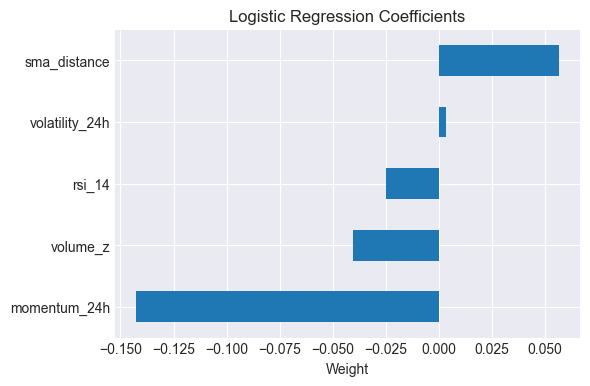

In [6]:
coef = pipeline.named_steps['model'].coef_[0]
coefs = pd.Series(coef, index=feature_cols).sort_values()
coefs.plot(kind='barh', figsize=(6, 4))
plt.title('Logistic Regression Coefficients')
plt.xlabel('Weight')
plt.show()

## 回測策略績效
若模型預測下一根 K 線會上漲 (> 0.5)，則持有多頭部位，否則空手。將策略報酬與單純持有比較。

In [7]:
backtest = df_features.iloc[split_index:].copy()
backtest = backtest.assign(
    probability=y_proba,
    prediction=y_pred,
    signal=(y_proba > 0.5).astype(int)
)
backtest['strategy_return'] = backtest['future_return'] * backtest['signal']
backtest['buy_hold_return'] = backtest['future_return']
backtest['strategy_equity'] = (1 + backtest['strategy_return']).cumprod()
backtest['buy_hold_equity'] = (1 + backtest['buy_hold_return']).cumprod()
backtest[['open_time', 'probability', 'signal', 'strategy_return']].head()

,open_time,probability,signal,strategy_return
2004,2025-08-16 17:00:00+00:00,0.511493,1,-0.000061
2005,2025-08-16 18:00:00+00:00,0.510764,1,-0.000116
2006,2025-08-16 19:00:00+00:00,0.500951,1,-0.000142
2007,2025-08-16 20:00:00+00:00,0.502508,1,-0.001727
2008,2025-08-16 21:00:00+00:00,0.508891,1,0.000071


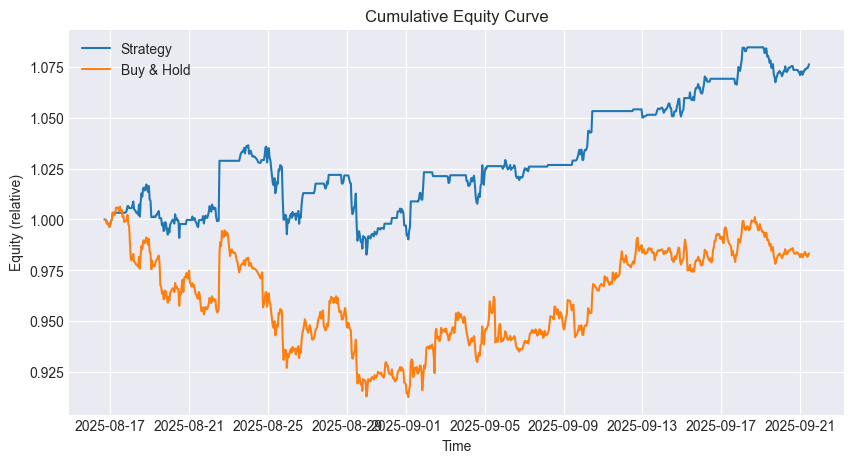

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(backtest['open_time'], backtest['strategy_equity'], label='Strategy')
plt.plot(backtest['open_time'], backtest['buy_hold_equity'], label='Buy & Hold')
plt.title('Cumulative Equity Curve')
plt.xlabel('Time')
plt.ylabel('Equity (relative)')
plt.legend()
plt.show()

## 結論與下一步
- Logistic Regression 可快速給出具有解釋性的方向預測，適合做為基準模型。
- 仍可嘗試更多技術指標、特徵選擇、或不同的機器學習模型，並加入交易成本後再次評估策略績效。